In [2]:
from tqdm.auto import tqdm

import sys
sys.path.insert(0, "./data/maps_1key_noaug/processed/Depth-Anything-V2")

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
from IPython.display import display
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.transforms import Resize, GaussianBlur
from depth_anything_v2.dpt import DepthAnythingV2


WARNING - 2024-12-18 11:56:44,143 - attention - xFormers not available
WARNING - 2024-12-18 11:56:44,144 - block - xFormers not available


In [2]:
torch.cuda.is_available()

True

In [3]:
class ImageMapsDataset(Dataset):
    def __init__(self, images_path, points_path=None):
        super().__init__()
        self.images_path = images_path
        self.points_path = points_path
        

    def __len__(self):
        return (len(os.listdir(self.images_path)) - 3) * 10
    
    def _prepare_map(self, points):
        x = points[:, 0]
        y = points[:, 2]

        x = ((x - x.min())/(x.max() - x.min())) * 319 / 2 + 80
        x = x.astype(np.int16)

        y = ((y - y.min())/(y.max() - y.min())) * 239 / 2 + 90
        y = y.astype(np.int16)

        pic = np.ones((240, 320))

        pic[-y, x] = np.zeros(len(y))
        
        return pic
    

    def __getitem__(self, index):
        i = index // 10
        j = index % 10
        
        data = np.load(f'{self.images_path}/map{i+1}_data.npz')
        
        points = np.asarray(o3d.io.read_point_cloud(f"{self.points_path}/map{i+1}_{j}.ply").points)
        points_padded = np.zeros((6000, 3))
        n = points.shape[0]
        left_shift = (6000 - n) // 2
        right_shift = left_shift + (6000 - n) % 2
        points_padded[left_shift:6000-right_shift, :] = points
        points_padded = torch.from_numpy(points_padded.T).to(torch.float32)
        
        im = data['images'][0,j,0]
        map = data['maps'][0,j,0]

        im = torch.from_numpy(im) / 255
        im = im.permute(0, 3, 1, 2)

        map = torch.from_numpy(map[:, :, 0]).unsqueeze(0) / 255
        points_map = torch.from_numpy(self._prepare_map(points)).unsqueeze(0).to(torch.float32)
        
        return im, points_map, map

        


        
images_path = "./data/maps_1key_noaug/processed"
points_path = "./data/point_clouds/point_clouds11"
train_dataset = ImageMapsDataset(images_path, points_path)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)


In [4]:
data = np.load(f'./data/maps_1key_noaug/processed/map{99}_data.npz', allow_pickle=True)

d1 = data['maps']
d2 = data['images']
d4 = data['depth']

In [5]:
# Function to create a transformation matrix from rotation and translation
def create_transformation_matrix(rotation, translation):
    transformation = np.eye(4)
    transformation[:3, :3] = rotation  # Assign rotation
    transformation[:3, 3] = translation  # Assign translation
    return transformation

# Function to transform a point cloud using a transformation matrix
def transform_point_cloud(pcd, transformation):
    pcd.transform(transformation)  # Apply the 4x4 transformation
    return pcd
# Load the point cloud from the uploaded .ply file
pcd = o3d.io.read_point_cloud("./data/point_clouds/point_clouds11/map99_1.ply")
points = np.asarray(pcd.points)

# Optionally, downsample the points for faster rendering
sample_rate = 20000  # Adjust as needed
if len(points) > sample_rate:
    indices = np.random.choice(len(points), sample_rate, replace=False)
    sampled_points = points[indices]
else:
    sampled_points = points

# Create Plotly scatter plot
scatter = go.Scatter3d(
    x=sampled_points[:, 0],
    y=sampled_points[:, 1],
    z=sampled_points[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=sampled_points[:, 2],
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    title='3D Point Cloud Visualization',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()

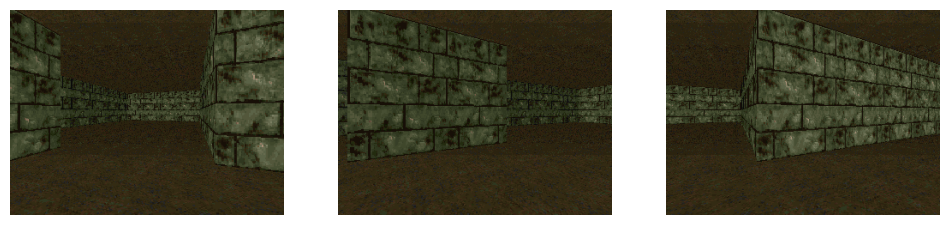

In [6]:


n1 = 1

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(d2[0, n1, 0 ,0])
ax[0].set_axis_off()
ax[1].imshow(d2[0, n1, 0 ,1])
ax[1].set_axis_off()
ax[2].imshow(d2[0, n1, 0 ,2])
ax[2].set_axis_off()

plt.savefig("./doomview3.png", dpi=200, bbox_inches='tight')

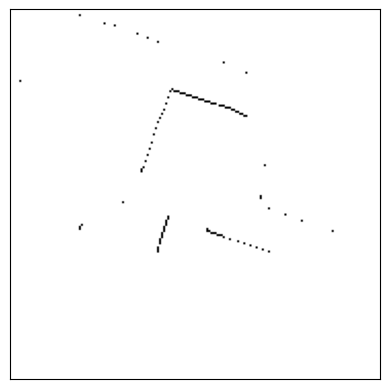

In [7]:
fig, ax = plt.subplots()

ax.imshow(d1[0,n1,0,:,:,])
plt.xlim(70, 250)
plt.ylim(180, 0)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("./doom_map.png", dpi=200, bbox_inches='tight')

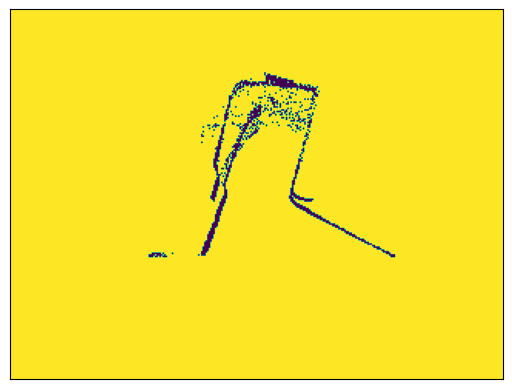

In [8]:
x = sampled_points[:, 0]
y = sampled_points[:, 2]

x = ((x - x.min())/(x.max() - x.min())) * 319 / 2 + 90
x = x.astype(np.int16)

y = ((y - y.min())/(y.max() - y.min())) * 239 / 2 + 80
y = y.astype(np.int16)

pic = np.ones((240, 320))

pic[-y, x] = np.zeros(len(y))

fig, ax = plt.subplots()
plt.imshow(pic)
ax.set_xticks([])
ax.set_yticks([])

plt.savefig("./doom_cloud.png", dpi=200, bbox_inches='tight')

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super().__init__()    
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1, stride=2), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Flatten(1),
            nn.Linear(features, 800),
            nn.ReLU(),
            nn.Linear(800, 400)
        )
        
    def forward(self, x):
        return self.encoder(x)
    
    
class ImagesEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super().__init__()    
        self.encoder1 = EncoderBlock(in_channels, out_channels, features)
        self.encoder2 = EncoderBlock(in_channels, out_channels, features)
        self.encoder3 = EncoderBlock(in_channels, out_channels, features)
    def forward(self, x1, x2, x3):
        x1 = self.encoder1(x1)
        x2 = self.encoder2(x2)
        x3 = self.encoder3(x3)
        return x1, x2, x3




class MapGenerator(nn.Module):
    def __init__(self, depth_model=None):
        super().__init__()
        
        self.depth_model = depth_model
        self.resize = Resize((210, 280))
        
        self.im_encoder = ImagesEncoder(3, 16, 4_800)
        self.depth_encoder = ImagesEncoder(1, 16, 3_536)
        self.points_encoder = EncoderBlock(1, 16, 4_800)
        
        self.make_embedding = nn.Sequential(
            nn.Linear(2800, 3_200),
            nn.ReLU(),
            nn.Linear(3_200, 4_800)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, kernel_size=2, stride=2),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 1, kernel_size=2, stride=2),
        )

    def forward(self, ims, points):
        im1, im2, im3 = ims[:, 0, :], ims[:, 1, :], ims[:, 2, :]
        
        with torch.no_grad():
            d1, d2, d3 = self.depth_model(self.resize(im1)), self.depth_model(self.resize(im2)), self.depth_model(self.resize(im3))
        
        im1, im2, im3 = self.im_encoder(im1, im2, im3)
        d1, d2, d3 = self.depth_encoder(d1.unsqueeze(1), d2.unsqueeze(1), d3.unsqueeze(1))
        
        points = self.points_encoder(points)
        x = torch.cat([im1, im2, im3, d1, d2, d3, points], axis=1)
        
        x = self.make_embedding(x)
        x = x.view(-1, 16, 15, 20)
        x = self.decoder(x)
        return x
    


In [10]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=2)
ex = None
for b in train_loader:
    ex = b
    break

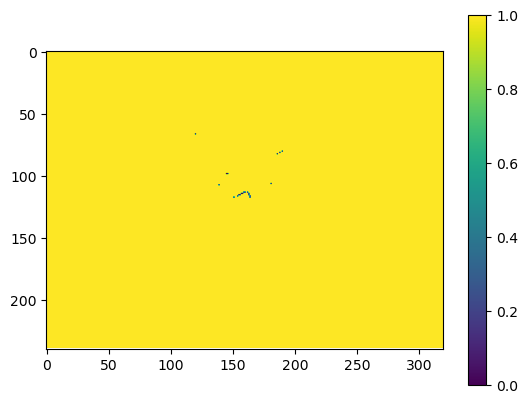

In [11]:

map = ex[-1][0, 0]
gb = GaussianBlur(kernel_size=1, sigma=0.1)
gb_map = gb(map.view(1, 240, 320))
gb_map = (gb_map - gb_map.min()) / (gb_map.max() - gb_map.min())
#gb_map[gb_map<1] = 0
plt.imshow(gb_map[0])
plt.colorbar()

In [14]:

depth_model = DepthAnythingV2(encoder='vits', features=64, out_channels=[48, 96, 192, 384])
depth_model.load_state_dict(torch.load('./data/maps_1key_noaug/processed/Depth-Anything-V2/depth_anything_v2_vits.pth', map_location='cpu'))
depth_model.eval();

xFormers not available
xFormers not available


In [15]:

res = Resize((210, 280))
depth_model(res(ex[0][0])).shape

torch.Size([3, 210, 280])

  0%|          | 0/8 [00:00<?, ?it/s]

loss:  0.5739188
loss:  0.55641145
loss:  0.53839487
loss:  0.5244835


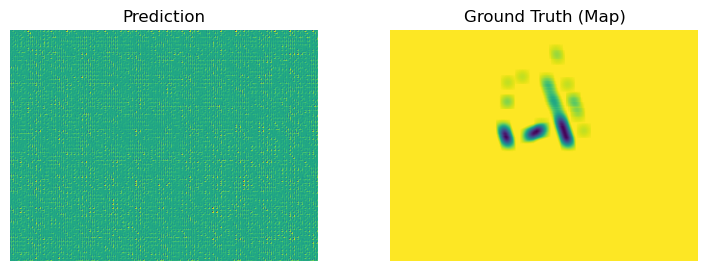

loss:  0.510115
loss:  0.4974073
loss:  0.48289442
loss:  0.4710427


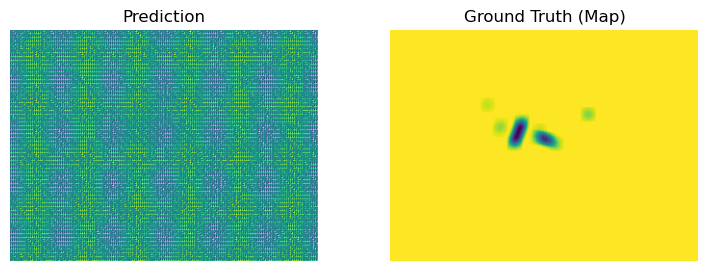

loss:  0.45654812
loss:  0.44319603
loss:  0.4269668
loss:  0.4124668


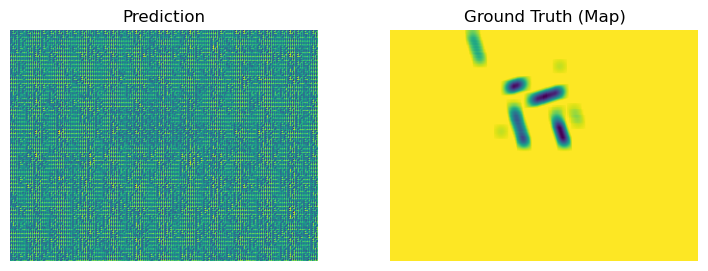

loss:  0.4002372
loss:  0.38446483
loss:  0.37141958
loss:  0.3578523


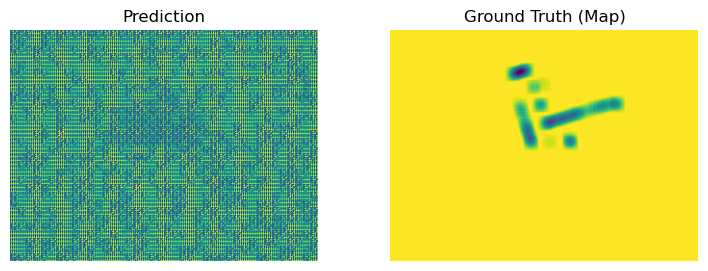

loss:  0.34353578
loss:  0.3331412
loss:  0.32073256
loss:  0.30492714


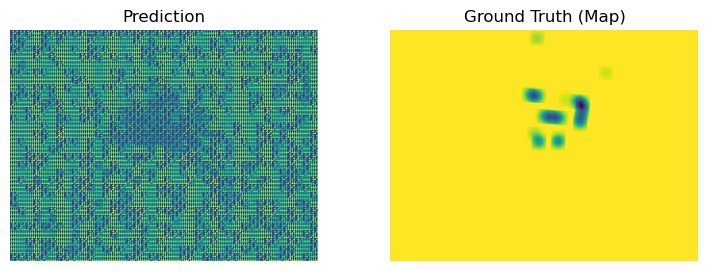

loss:  0.2947535
loss:  0.28461215
loss:  0.2689148
loss:  0.25854075


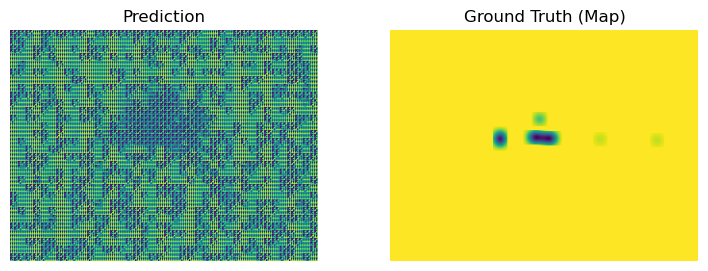

loss:  0.24998349
loss:  0.2389192
loss:  0.22771277
loss:  0.21518068


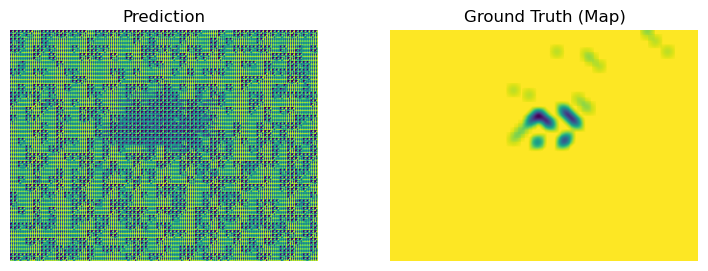

loss:  0.21052387
loss:  0.20036685
loss:  0.19058871
loss:  0.18784767


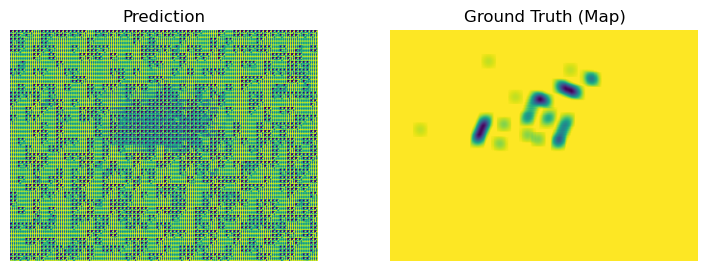

In [21]:
def gauss_pixel_loss(y_true, y_pred, loss_fn, gb):
    EPS = 1e-7
    y_true = gb(y_true)
    y_true = (y_true - y_true.min()) / (y_true.max() - y_true.min() + EPS)
    y_true[y_true < 0.9] = 0
    return loss_fn(y_pred, y_true)

gb = GaussianBlur(kernel_size=15, sigma=5)

torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=250)
model = MapGenerator(depth_model)
losses = []
max_epoch = 8
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
loss_fn = nn.BCELoss()

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-2)


for _ in tqdm(range(max_epoch)):
    model.train()
    for ims, points, maps in train_loader:
        optimizer.zero_grad()
        ims, points, maps = ims.to(device), points.to(device), maps.to(device)
        output = model(ims,points)
        output = torch.sigmoid(output)
        loss = gauss_pixel_loss(maps, output, loss_fn, gb)
        print("loss: ", loss.detach().cpu().numpy())
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()

    fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
    ex = torch.sigmoid(output[0].detach().cpu()).numpy()[0]
    mp = gb(maps[0].detach().cpu()).numpy()[0]
    ax[0].imshow(ex)
    ax[0].set_axis_off()
    ax[0].set_title("Prediction")
    ax[1].imshow(mp)
    ax[1].set_axis_off()
    ax[1].set_title("Ground Truth (Map)")
    plt.show()


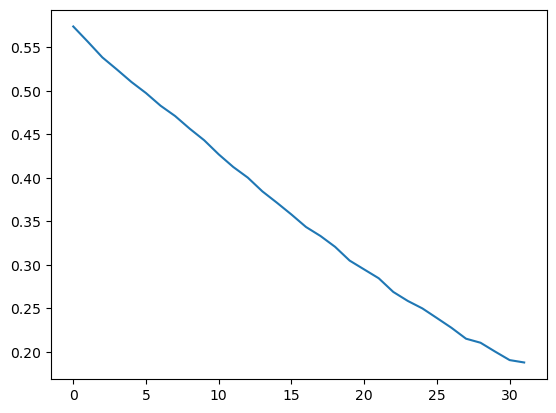

In [22]:
plt.plot(losses)

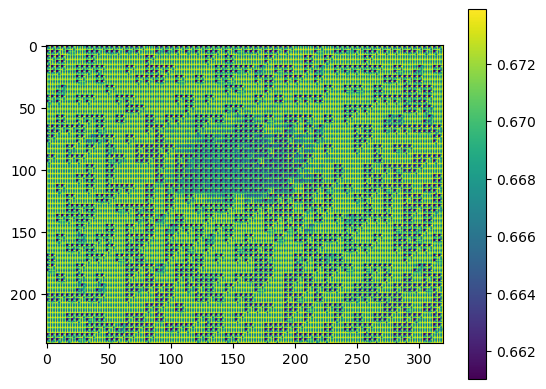

In [23]:
plt.imshow(torch.sigmoid(torch.from_numpy(ex)))
plt.colorbar()

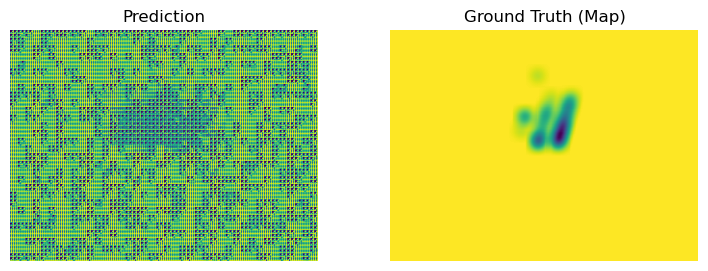

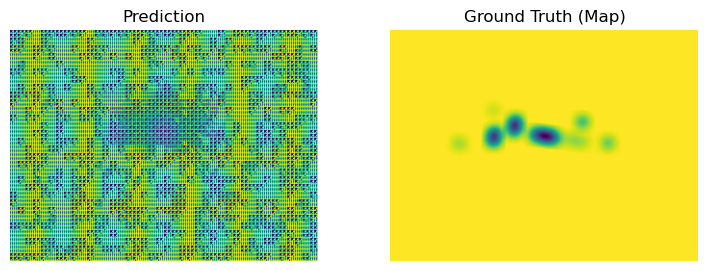

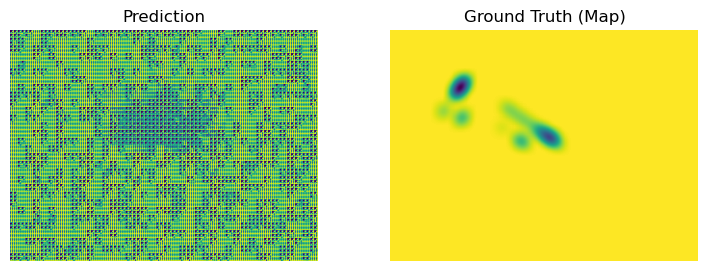

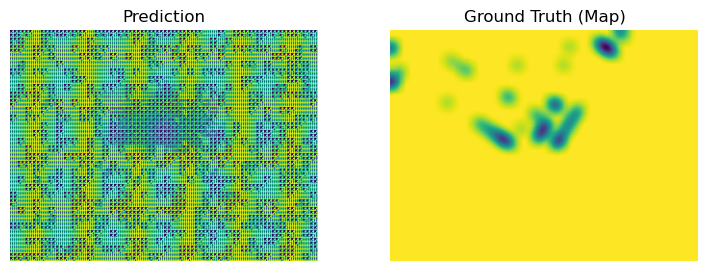

In [24]:
i = 0
gb = GaussianBlur(kernel_size=25, sigma=6)
for ims, points, maps in train_loader:
    ims, points, maps = ims.to(device), points.to(device), maps.to(device)
    output = model(ims,points)
    
    fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
    ex = torch.sigmoid(output[1].detach().cpu()).numpy()[0]
    mp = gb(maps[1].detach().cpu()).numpy()[0]
    ax[0].imshow(ex)
    ax[0].set_axis_off()
    ax[0].set_title("Prediction")
    ax[1].imshow(mp)
    ax[1].set_axis_off()
    ax[1].set_title("Ground Truth (Map)")
    plt.show()
    
    i += 1
    if i > 10:
        break